# Titanic competition - predict survival

## Data Exploration

Start by exploring the data

Information about the data can be found here: https://www.kaggle.com/competitions/titanic/data?select=train.csv

In [68]:
import pandas as pd

import numpy as np
np.random.seed(0)

df = pd.read_csv("C:/Users/arthu/OneDrive/Documents/jupyter/titanic/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's look at the overall shape first.

In [69]:
df.shape

(891, 12)

So there are 891 rows, 12 columns.

I will investigate the columns below and as I find information, I will add it to a summary dataframe, feature_info.

### Basic data investigation

Let's start by looking at how much missing data there is in each column.

In [70]:
feature_info = df.isnull().sum().to_frame()
feature_info = feature_info.rename(columns={0: "missing_values"})

Age:
I should investigate whether there is any pattern to the missing values. 

Cabin:
From some brief research online, it appears that all passengers - even third class passengers - did have assigned cabins. However, information about who had which cabin is largely unavailable. One source mentions that cabin allocations are largely only known for first class passengers - perhaps I could check if that is the case in this data. Ideally, it would be useful to be able to translate the cabin number into information about the person's position in the ship - fore or aft, port or starboard, and which deck. Where cabin numbers are missing, we can try to infer as much as we can from Pclass.

Embarked:
There are only two missing values in the training data. I might have to label encode this column so can encode 'no data' as a separate label.

I will now add these notes, along with notes provided in the data documentation, into a 'notes' column in the feature_info DataFrame.

In [71]:
#These are the definitions given in the documentation about the data
feature_definitions = pd.Series([
    "Passenger ID",
    "0 = died, 1 = survived",
    "Ticket class: 1, 2 or 3",
    "Name",
    "Sex",
    "Age in years",
    "Number of siblings / spouses aboard",
    "Number of parents / children aboard",
    "Ticket number",
    "Passenger fare",
    "Cabin number",
    "Port of embarkation: C = Cherbourg, Q = Queenstown, S = Southampton"
], index=df.columns)

#Create a new column to contain these definitions and any other notes we want to add 
feature_info = feature_info.assign(notes = feature_definitions)

#Create a quick way to neatly add notes on the notes column
def add_note(feature, note):
    if not feature_info.loc[feature, "notes"] is None:
        if str(feature_info.loc[feature, "notes"])[-1] == ".":
            feature_info.loc[feature, "notes"] = str(feature_info.loc[feature, "notes"]) + " " + note
        else:
            feature_info.loc[feature, "notes"] = str(feature_info.loc[feature, "notes"]) + ". " + note
    else:
        feature_info.loc[feature, "notes"] = note
    
add_note("Pclass", "A proxy for socio-economic status (SES); 1st = Upper, 2nd = Middle, 3rd = Lower")
add_note("Age", "177 missing values - investigate if there is a pattern to this. Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5")
add_note("SibSp", "The dataset defines family relations in this way... Sibling = brother, sister, stepbrother, stepsister, Spouse = husband, wife (mistresses and fiancés were ignored)")
add_note("Parch", "The dataset defines family relations in this way... Parent = mother, father; Child = daughter, son, stepdaughter, stepson; Some children travelled only with a nanny, therefore parch=0 for them.")
add_note("Cabin", "From some brief research online, it appears that all passengers - even third class passengers - did have assigned cabins. However, information about who had which cabin is largely unavailable. One source mentions that cabin allocations are largely only known for first class passengers - perhaps I could check if that is the case in this data. Ideally, it would be useful to be able to translate the cabin number into information about the person's position in the ship - fore or aft, port or starboard, and which deck. Where cabin numbers are missing, we can try to infer as much as we can from Pclass.")
add_note("Embarked", "There are only two missing values in the training data. I might have to label encode this column so can encode 'no data' as a separate label.")

feature_info["notes"] = feature_info["notes"].fillna("")

pd.set_option('display.max_colwidth', None)

It would also be useful to include the data type and number of unique values of each of the features in the table.

In [72]:
#Add a column containing the data type of each of the features
feature_info["dtype"] = df.dtypes

#Add a column containing the number of unique values
feature_info["unique_values"] = df.nunique()

### Mutual information

Next, it might be useful to measure the mutual information of all of the features, so I'll add that to the table too.

In [73]:
from sklearn.feature_selection import mutual_info_classif

#Create a copy of the dataframe that we can modify for use with the mutual information algorithm
X_mi = df.copy()
y_mi = X_mi.pop("Survived")

#Quickly deal with missing values in an easy way
#Fill missing values in the 'Cabin' column with the class of travel
X_mi["Cabin"] = X_mi["Cabin"].fillna(X_mi["Pclass"])
#Impute 'Age' using the mean
X_mi["Age"] = X_mi["Age"].fillna(X_mi["Age"].mean())
#Impute 'Embarked' using the mode
X_mi["Embarked"] = X_mi["Embarked"].fillna(X_mi["Embarked"].mode()[0])

#Quick label encoding for categorical variables
for colname in X_mi.select_dtypes("object"):
    X_mi[colname], _ = X_mi[colname].factorize()

#All the integer features are discrete
disc_feats = X_mi.dtypes == int

mi_scores = mutual_info_classif(X_mi, y_mi, discrete_features=disc_feats, random_state=0)

scores_dict = {}

for i in range(0, 11):
    scores_dict[X_mi.columns[i]] = mi_scores[i]
    
feature_info = feature_info.assign(mutual_info = pd.Series(scores_dict))
feature_info.loc["Survived", "mutual_info"] = "Not applicable"

#Display the results in descending order, with the target removed from the table to allow sorting
feature_info.drop("Survived", axis=0).sort_values("mutual_info", ascending=False)

,missing_values,notes,dtype,unique_values,mutual_info
Sex,0,Sex,object,2,0.155741
Fare,0,Passenger fare,float64,248,0.122319
Ticket,0,Ticket number,object,681,0.084632
Cabin,687,"Cabin number. From some brief research online, it appears that all passengers - even third class passengers - did have assigned cabins. However, information about who had which cabin is largely unavailable. One source mentions that cabin allocations are largely only known for first class passengers - perhaps I could check if that is the case in this data. Ideally, it would be useful to be able to translate the cabin number into information about the person's position in the ship - fore or aft, port or starboard, and which deck. Where cabin numbers are missing, we can try to infer as much as we can from Pclass.",object,147,0.064692
Pclass,0,"Ticket class: 1, 2 or 3. A proxy for socio-economic status (SES); 1st = Upper, 2nd = Middle, 3rd = Lower",int64,3,0.04084
Embarked,2,"Port of embarkation: C = Cherbourg, Q = Queenstown, S = Southampton. There are only two missing values in the training data. I might have to label encode this column so can encode 'no data' as a separate label.",object,3,0.034825
Name,0,Name,object,891,0.016819
PassengerId,0,Passenger ID,int64,891,0.01653
Age,177,"Age in years. 177 missing values - investigate if there is a pattern to this. Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5",float64,88,0.015774
Parch,0,"Number of parents / children aboard. The dataset defines family relations in this way... Parent = mother, father; Child = daughter, son, stepdaughter, stepson; Some children travelled only with a nanny, therefore parch=0 for them.",int64,7,0.014449


### Feature engineering

Based on the above information, I will now conduct some further investigation of individual features and start making changes to a 'df_modified' DataFrame which I will use for the modelling.

In [74]:
df_modified = df.copy()

#### Sex

We can sum up the relationship between Sex and survival by simple noting what fraction of passengers of each gender survived:

In [75]:
print(
    "Male survival rate: ", 
    df.loc[(df["Sex"] == "male") & (df["Survived"] == 1)].shape[0] / df.loc[df["Sex"] == "male"].shape[0], 
    "\nFemale survival rate: ",  
    df.loc[(df["Sex"] == "female") & (df["Survived"] == 1)].shape[0] / df.loc[df["Sex"] == "male"].shape[0]
)

Male survival rate:  0.18890814558058924 
Female survival rate:  0.4038128249566724


So female passengers were more than twice as likely to survive. This is clearly a useful feature. We merely need to label encode the 'Sex' feature to make it work in the model.

In [76]:
df_modified["Sex"], _ = df_modified["Sex"].factorize()
add_note("Sex", "Label encode this feature.")

#### Fare

For the fare, we can look at a boxen plot:

<AxesSubplot: xlabel='Survived', ylabel='Fare'>

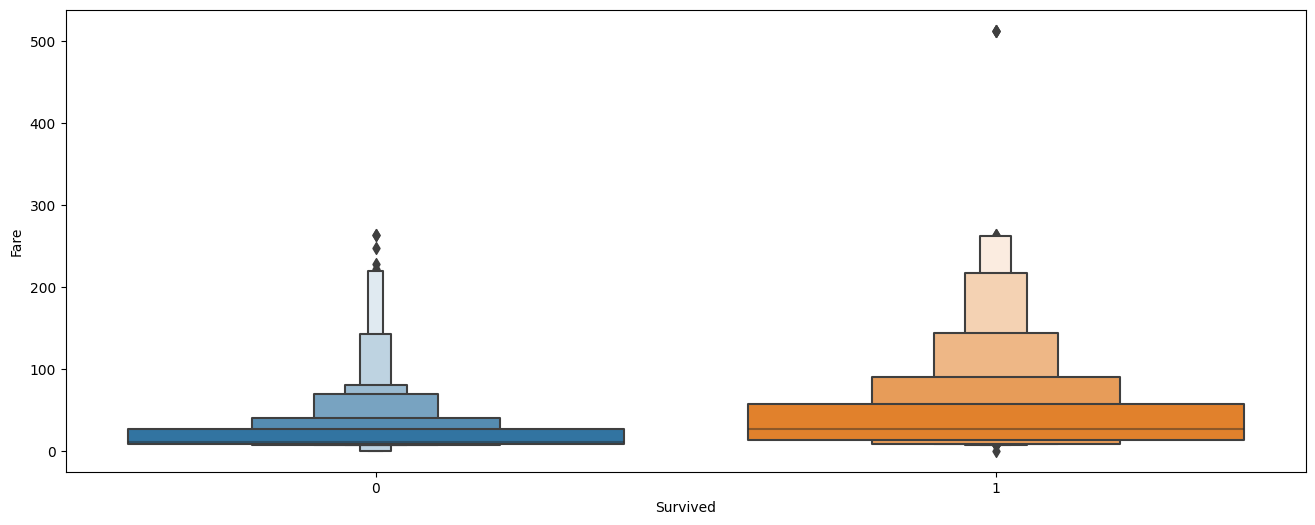

In [77]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns

matplotlib.rcParams['figure.figsize'] = [16, 6]

sns.boxenplot(x=df["Survived"], y=df["Fare"])

There is significant overlap, but those who paid more were clearly more likely to survive. This is a continuous numerical feature and can be left as-is.

In [78]:
add_note("Fare", "Use this feature as-is.")

#### Ticket number

It seems surprising that the ticket number's mutual information score is as high as it is. Why might this be? 

I have done some online research around the systems used to sell tickets, and there are no obvious ways in which this feature could influence the odds of survival. 

Perhaps the ticket number appears to be a strong predictor of survival because the algorithm can learn which passengers survived and what their ticket numbers were, and thus use ticket number to predict survival, but not survival to predict ticket number. If this is the case, then the Ticket feature would not be a useful one, and using it could lead to overfitting. It may be best to remove this feature from the training data.

In some cases there are two components to the ticket number, separated by a space. Perhaps separating these components could be illuminating?

In [79]:
add_note("Ticket", "It seems this feature lacks value and could be removed before training the model, unless there is something useful to glean from separating the components of the values which contain a space.")
df_modified = df_modified.drop("Ticket", axis=1)

#### Cabin number

For the MI calculation, the 'Cabin' feature was filled with 'Pclass' values where actual cabin numbers were missing, so it is interesting that this feature scores more highly than 'Pclass'. This seems to imply that the cabin numbers that *are* available do add some useful information. As I thought initially, it would probably be worth investigating what cabin number means in terms of position on board.

It seems likely that the deck that passengers' cabins were on could affect how quickly they were able to reach lifeboats, or how quickly the route from their cabins was flooded after the initial collision. I will therefore try replacing the 'Cabin' feature with a 'Deck' feature derived from the letter component of the cabin number.

In order to help the model make sense of this categorical data, I will also try to encode it in such a way that the people I expect to have been best positioned to escape the ship (based on their cabin position) have the highest integer value in this feature. On first principles, I would expect that the people closest to the lifeboats would have had the advantage, and the farther a cabin was away from the uppermost boat deck (where all but two of the lifeboats were located), the lower the number I should assign them.

|Deck letter | Integer encoding |
|-------------|--------------|
|T (boat deck) |8 |
|A |7 |
|B |6 |
|C |5 |
|D |4 |
|E |3 |
|F |2 |
|G |1 |

There are some cases where the cabin number(s) of a passenger mention two decks, e.g. 'EF' and 'FG'. I will encode these as the average of the decks mentioned.

Where no cabin number data is available, I will try infer the likely deck from the Pclass feature. I have found some information on titanic.fandom.com which may help. There were first class cabins on six decks: six on the boat deck (labelled differently from other cabins, with a single letter; only one of these, 'T', was occupied), 36 on A, 101 on B, 134 on C, 49 on D, and 45 on E. There were second class cabins on three decks: 39 on D, 65 on E and 64 on F. I will use weighted averages for first and second class:

$w_{1st} = \frac{36\times7 + 101\times6 + 134\times5 + 49\times4 + 45\times3}{36 + 101 + 134 + 49 + 45} = 5.09$

$w_{2nd} = \frac{39\times4 + 65\times3 + 64\times2}{39 + 65 + 64} = 2.85$

Third class cabins were mostly on F deck, a few on D and E, and some on G. I will therefore assume that third class passengers whose cabin numbers are unknown were on F deck.

When encoding this information, I will rename the column 'Boat_Proximity' for clarity.

<AxesSubplot: xlabel='Survived', ylabel='Boat_Proximity'>

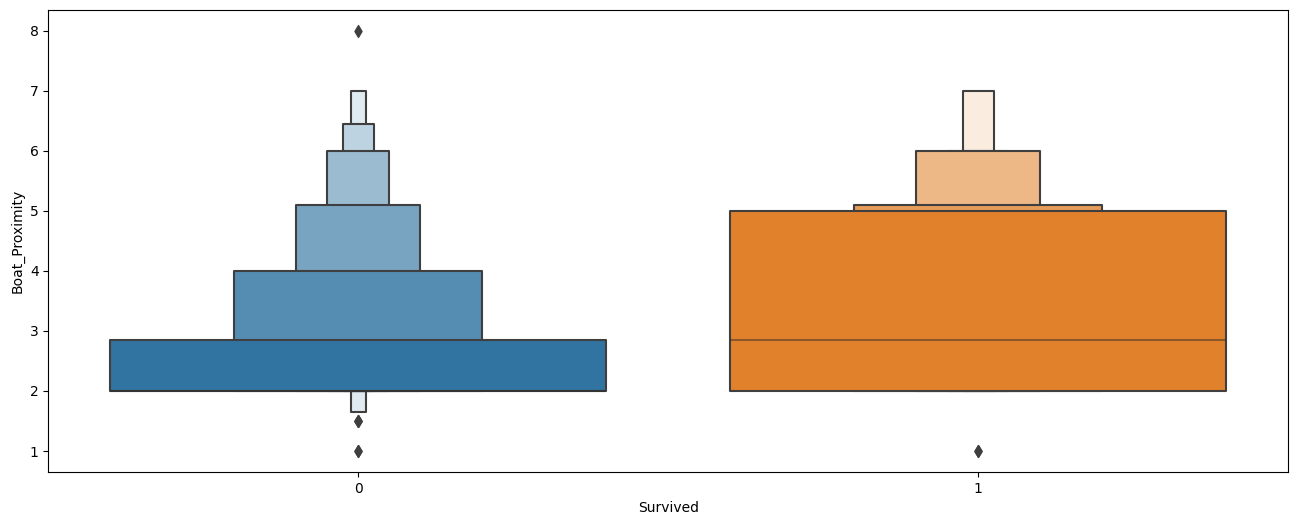

In [80]:
#Create separate columns for the letter and number components

def get_cabin_letters(st):
    if type(st) == float:
        return st
    rtnval = ""
    for c in st:
        if c.isalpha():
            if c not in rtnval:
                rtnval += c
    return "".join(sorted(rtnval))
    
df_modified["Deck"] = df["Cabin"].map(get_cabin_letters)
df_modified = df_modified.drop("Cabin", axis=1)

deck_encoding = {"A": 7, "B": 6, "C": 5, "D": 4, "E": 3, "F": 2, "G": 1, "T": 8}
pclass_deck_encoding = {1: 5.09, 2: 2.85, 3: 2}

def encode_deck(r):
    #Where there isn't a cabin number, use the weighted average of decks for the passenger's Pclass
    if type(r["Deck"]) == float:
        return pclass_deck_encoding[r["Pclass"]]
    #If the passenger's cabin number(s) mentioned multiple decks, take the average of those
    elif len(r["Deck"]) > 1:
        sum_of_decks = 0
        for letter in r["Deck"]:
            sum_of_decks += deck_encoding[letter]
        return sum_of_decks / len(r["Deck"])
    #If all is well and the cabin number mentions a single deck, use the corresponding value of Boat_Proximity
    else:
        return deck_encoding[r["Deck"]]
                                    
df_modified["Boat_Proximity"] = df_modified.apply(encode_deck, axis=1)
df_modified = df_modified.drop("Deck", axis=1)

add_note("Cabin", "Replace this feature with one characterising the estimated proximity of a passenger's cabin to the lifeboats.")

sns.boxenplot(x=df_modified["Survived"], y=df_modified["Boat_Proximity"])

The plot suggests that Boat_Proximity will be a useful feature.

#### Class
It is interesting that this the 'Pclass' feature isn't a stronger predictor, given that 'Fare' is a high scorer and I would expect Pclass and Fare to be closely correlated. I should check the relationship between these, perhaps using a swarm visualisation or similar. If Pclass is indeed strongly correlated with Fare but doesn't have a similar mutual information score, perhaps this is something to do with the number of people represented in each of the Pclass buckets.

<AxesSubplot: xlabel='Pclass', ylabel='Fare'>

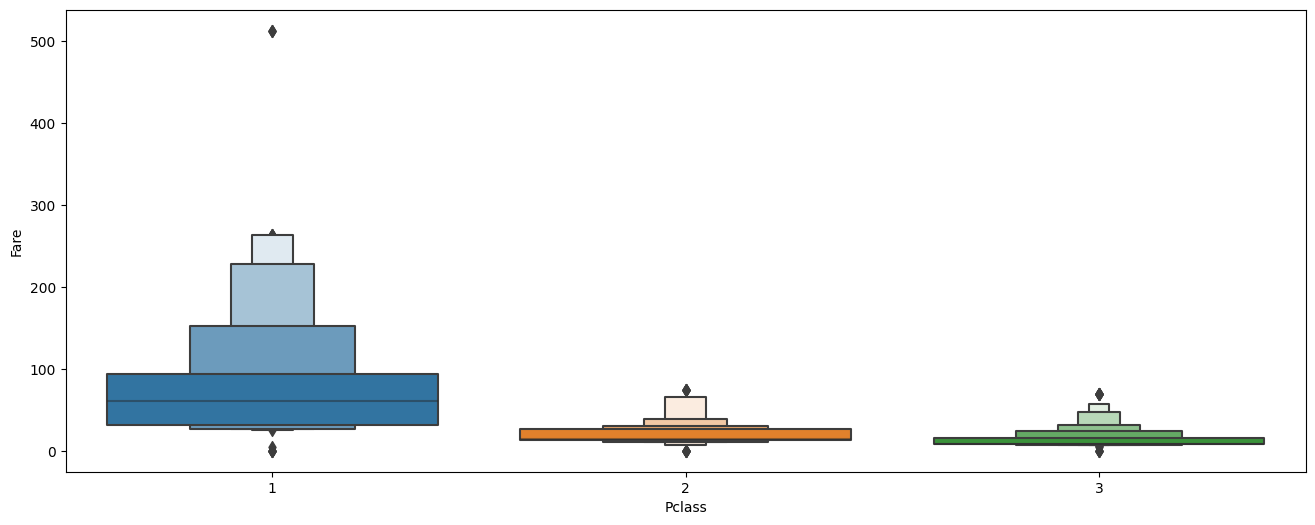

In [81]:
sns.boxenplot(x=df["Pclass"], y=df["Fare"])

There appears to be a strong relationship between Fare and Pclass, as we would expect, even if there is a certain amount of overlap between the fares paid for tickets in the different classes.

Let's look at the survival rates by Pclass:

<AxesSubplot: xlabel='Pclass', ylabel='Survived'>

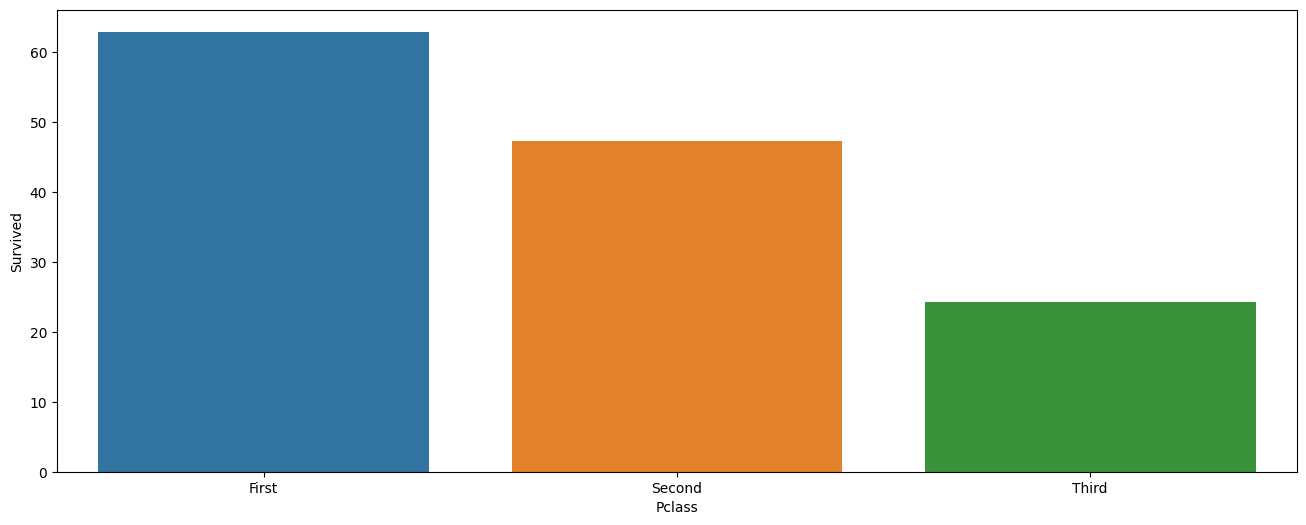

In [82]:
pclass_groupings_survival = df.groupby("Pclass")["Survived"]
pclass_survival_pct = 100 * pclass_groupings_survival.sum() / pclass_groupings_survival.count()
pclass_survival_pct = pclass_survival_pct.rename(index={1: "First", 2: "Second", 3: "Third"})

pclass_survival_pct

sns.barplot(x=pclass_survival_pct.index, y=pclass_survival_pct)

This looks like a strong relationship, so I will keep the Pclass feature as-is; it doesn't require label-encoding.

In [83]:
add_note("Pclass", "Use this feature as-is.")

#### Port of embarkation
The 'Embarked' feature also has a reasonably high mutual information score, and it isn't immediately obvious why this would be the case.

In [84]:
print(
    "Southampton survival rate: ", 
    df.loc[(df["Embarked"] == "S") & (df["Survived"] == 1)].shape[0] / df.loc[df["Embarked"] == "S"].shape[0], 
    "\nCherbourg survival rate: ",  
    df.loc[(df["Embarked"] == "C") & (df["Survived"] == 1)].shape[0] / df.loc[df["Embarked"] == "C"].shape[0],
    "\nQueenstown survival rate: ",  
    df.loc[(df["Embarked"] == "Q") & (df["Survived"] == 1)].shape[0] / df.loc[df["Embarked"] == "Q"].shape[0],
)

Southampton survival rate:  0.33695652173913043 
Cherbourg survival rate:  0.5535714285714286 
Queenstown survival rate:  0.38961038961038963


For some reason, it seems people who boarded in Cherbourg were considerably more likely to survive the sinking. It is not clear why this is the case, but this feature does seem to be useful so I will leave it as-is.

There are some missing values, however. Two options for dealing with this spring to mind initially - either filling these with the modal value, if the number of people boarding at the modal port is significantly higher than elsewhere, or filling these with another value to represent 'unknown'. Let's see how many people boarded at each port:

In [85]:
print(
    "Southampton embarkation numbers: ", 
    df.loc[(df["Embarked"] == "S")].shape[0], 
    "\nCherbourg embarkation numbers: ",  
    df.loc[(df["Embarked"] == "C")].shape[0],
    "\nQueenstown embarkation numbers: ",  
    df.loc[(df["Embarked"] == "Q")].shape[0]
)

Southampton embarkation numbers:  644 
Cherbourg embarkation numbers:  168 
Queenstown embarkation numbers:  77


There is a preponderance of passengers boarding in Southampton, and there are only few missing values in the Embarked feature, so we can probably safely fill the missing values with 'S'. Once this is done, we should also label encode this feature.

In [86]:
df_modified["Embarked"].fillna("S")
df_modified["Embarked"], _ = df_modified["Embarked"].factorize()

add_note("Embarked", "Use this feature, but fill in missing values with 'S' and label encode the category.")

#### Age
Based on the fact that I believe there was a preference for saving children, I am surprised that Age wasn't a stronger predictor. But this might be because beyond a certain age threshold, the relationship of 'younger means more likely to survive' falls away, or even is reversed if elderly passengers were given assistance. Alternatively, the relatively weak performance of the Age feature could be because children were more likely to be helped onto lifeboats, but also more likely to succumb to the cold, for example, or less likely to be able to find their way to the lifeboats if they weren't assisted. Perhaps it would be worth transforming this feature into a categorical one which sorts the passengers into categories like 'child'/'teen'/'adult'/'elderly'? To decide what to do, let's look at survival rate by age:

<AxesSubplot: xlabel='Survival rate', ylabel='Survived'>

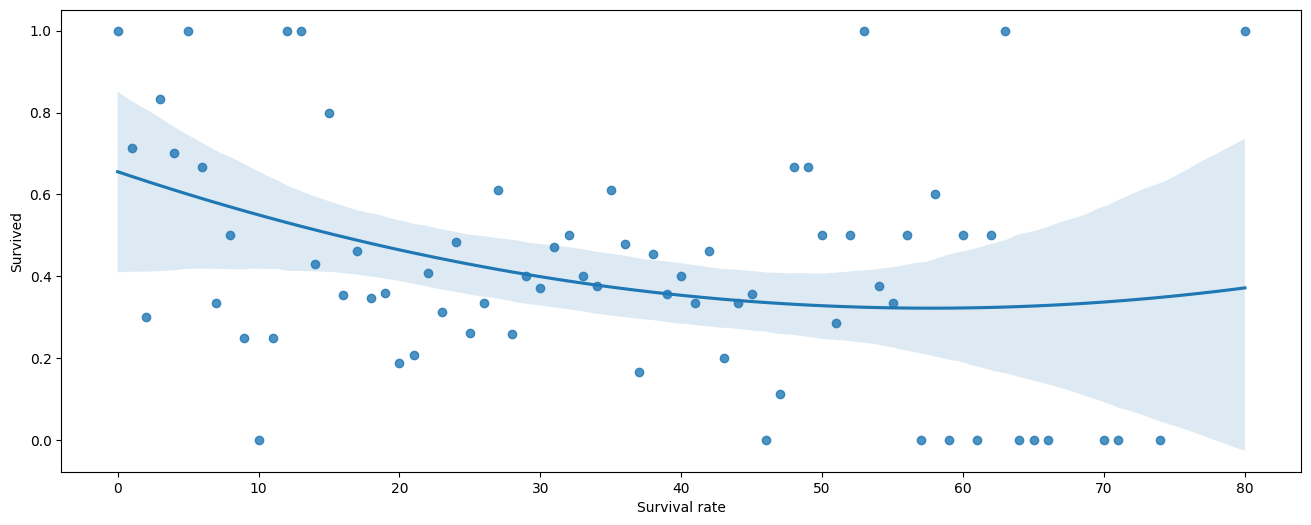

In [87]:
df_age_floor = df.copy()
df_age_floor["Age"] = np.floor(df_age_floor["Age"])
age_survival_rates = df_age_floor.groupby("Age")["Survived"].sum() / df_age_floor.groupby("Age")["Survived"].count()

age_survival_rates = age_survival_rates.rename_axis("Survival rate")

sns.regplot(x=age_survival_rates.index, y=age_survival_rates, order=2)

There does appear to be a relationship, but the data is noisy. Perhaps grouping the ages in ten-year bins would make the relationship clearer:

<AxesSubplot: xlabel='Age_Bin', ylabel='Survived'>

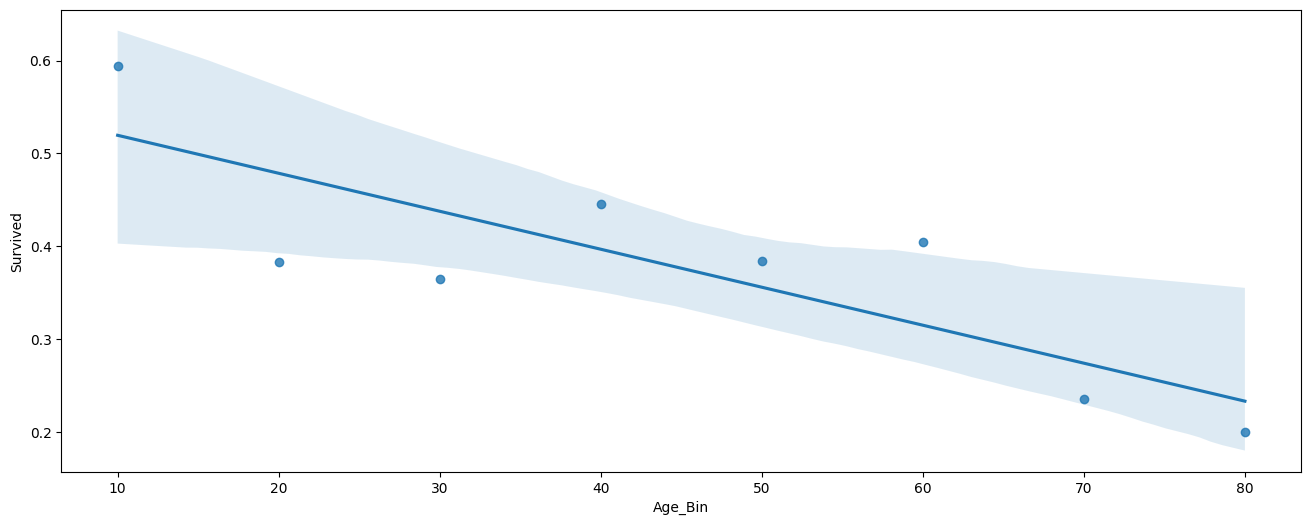

In [88]:
bin_list = pd.interval_range(start=0, end=80, freq=10)

df_age_test = df_modified.copy()

df_age_test["Age_Bin"] = pd.cut(df["Age"], bin_list)

age_range_survival_rates = df_age_test.groupby("Age_Bin")["Survived"].sum() / df_age_test.groupby("Age_Bin")["Survived"].count()

age_range_survival_rates = age_range_survival_rates.to_frame().reset_index()

age_range_survival_rates["Age_Bin"] = age_range_survival_rates["Age_Bin"].map(lambda r: int(str(r).split(" ")[1][0:-1]))

sns.regplot(x=age_range_survival_rates["Age_Bin"], y=age_range_survival_rates["Survived"])

This implies that the relationship between age and likelihood of survival is close enough to linear. I had wondered whether the survival rate would be significantly lower in the middle age ranges (30-60) because more vulnerable (younger and older) groups were prioritised, but according to the above, if anything, the reverse is true. There probably therefore isn't a need to change this continuous variable into a categorical one. We can use the Age feature as-is.

In [89]:
add_note("Age", "Use this feature as-is.")

#### Presence of family
Similarly, I might have expected 'Parch' to be a stronger predictor, as I would have expected parents and children to be given preferential treatment together. But perhaps this isn't strong because the quantity of parents/children doesn't matter, but merely whether the number of parents/children is greater than zero. Perhaps I could try changing this one into a categorical feature.

Let's try some visualisations:

<AxesSubplot: xlabel='Parch', ylabel='Survived'>

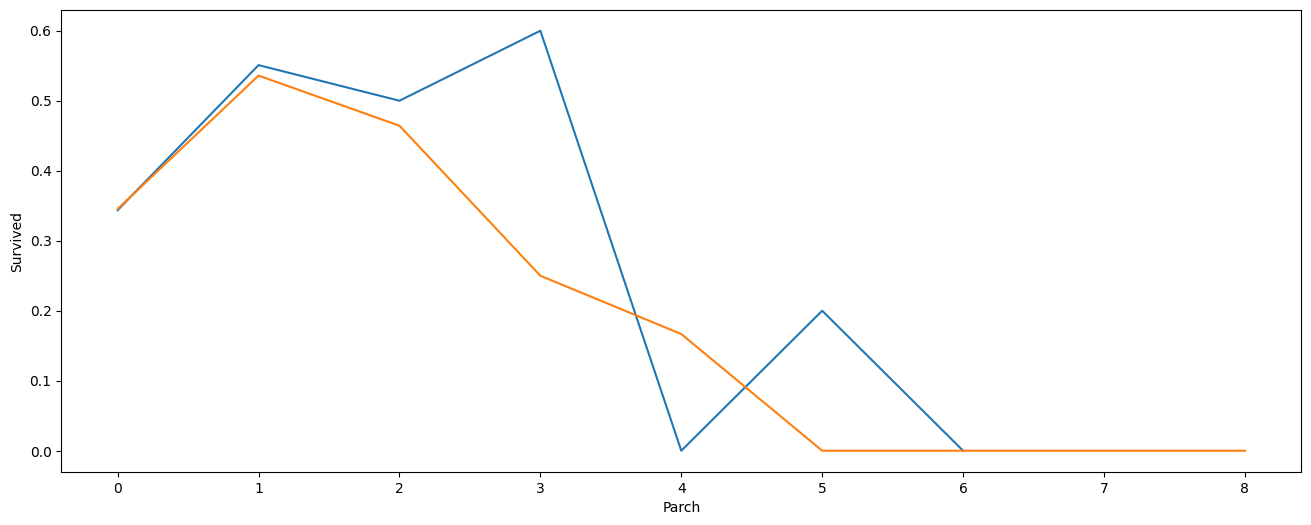

In [90]:

parch_survival_rates = df.groupby("Parch")["Survived"].sum() / df.groupby("Parch")["Survived"].count()
sns.lineplot(x=parch_survival_rates.index, y=parch_survival_rates)
sibsp_survival_rates = df.groupby("SibSp")["Survived"].sum() / df.groupby("SibSp")["Survived"].count()
sns.lineplot(x=sibsp_survival_rates.index, y=sibsp_survival_rates)

There appears to be a pattern whereby small numbers of relatives increase the odds of survival, but greater numbers begin to decrease the odds. The mutual information score was presumably low for this because it would not be possible to predict how many parents/children/siblings/spouses a passenger had based on whether or not they survived, but this might still be a useful feature with the inference going in the other direction. I will try keeping these features as they are.

In [91]:
add_note("Parch", "Use this feature as-is.")
add_note("SibSp", "Use this feature as-is.")

### Making a pipeline

I will now set up a pipeline, using the above decisions about preprocessing, and selecting a machine learning algorithm to use.

First, setting up the preprocessor:

In [92]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer

#Tasks for preprocessor:
##Drop PassengerId
##Drop Name
##Label-encode Sex
##Fill missing values in Age with the median
##Drop Ticket
##Drop Cabin and replace with new Boat_Proximity feature
##Fill missing values in Embarked with 'S', and label-encode it
##Keep the remainder of features as they are (Pclass, SibSp, Parch, Fare)

deck_encoding = {"A": 7, "B": 6, "C": 5, "D": 4, "E": 3, "F": 2, "G": 1, "T": 8}
pclass_deck_encoding = {1: 5.09, 2: 2.85, 3: 2}

#Define the special function for transforming the Cabin feature
def encode_cabin(df):
    rows_count = df.shape[0]
    for i in df.index:
        if pd.isna(df.loc[i, "Cabin"]):
            #Where there isn't a cabin number, use the weighted average of decks for the passenger's Pclass
            df.loc[i, "Cabin"] = pclass_deck_encoding[df.loc[i, "Pclass"]]
        else:
            #Get the letter(s) from the cabin number(s)
            cabin_letter_s = ""
            for c in df.loc[i, "Cabin"]:
                if c.isalpha():
                    if c not in cabin_letter_s:
                        cabin_letter_s += c
            cabin_letter_s = "".join(sorted(cabin_letter_s))
            #If the passenger's cabin number(s) mentioned multiple decks, take the average of those
            if len(cabin_letter_s) > 1:
                sum_of_decks = 0
                for letter in cabin_letter_s:
                    sum_of_decks += deck_encoding[letter]
                df.loc[i, "Cabin"] = sum_of_decks / len(cabin_letter_s)
            #If all is well and the cabin number mentions a single deck, use the corresponding value of Boat_Proximity
            else:
                df.loc[i, "Cabin"] = deck_encoding[cabin_letter_s]
    return df
    
def label_encode(df):
    for col in df.columns:
        df[col], _ = df[col].factorize()
    return df

def fill_median(col):
    return col.fillna(col.median())

#The main preprocessor combines all the tasks listed in the comment above

preprocessor_main = ColumnTransformer(
    transformers=[
        ('label_encode', FunctionTransformer(label_encode), ["Sex", "Embarked"]),
        ('fill_median', FunctionTransformer(fill_median), ["Age"]),
        ('cabin_transform', FunctionTransformer(encode_cabin), ["Cabin", "Pclass"]),
        ('keep_as_is', 'passthrough', ["Pclass", "SibSp", "Parch", "Fare"])
    ],
    remainder='drop'
)

#As a last resort, we also include a second preprocessor which just fills any remaining missing values in a very simple way

categorical_cols = [cname for cname in df.columns if df[cname].dtype == "object"]
numerical_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]

preprocessor_lastresort = ColumnTransformer(
    transformers=[
        ('categorical', SimpleImputer(strategy='median'), categorical_cols),
        ('numerical', SimpleImputer(strategy='most_frequent'), numerical_cols)
    ]
)

Next, we select the machine learning algorithm to use. Initially, I will try using XGBoost. Using this to create the overall pipeline gives:

In [112]:
#from xgboost import XGBRegressor

#model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100)

pipeline = Pipeline(steps=[
    ('preprocessor_main', preprocessor_main),
    #('preprocessor_lastresort', preprocessor_lastresort),
    ('model', model)
])

## Cross validation

We are working with a small dataset, so it would be wise to use cross-validation.

In [113]:
#First, checking the pipeline is working

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#X = df.copy()
#y = X.pop("Survived")
#
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
#
#pipeline.fit(X_train, y_train)
#preds = pipeline.predict(X_valid)
#
#
#print(accuracy_score(y_valid, preds))

from sklearn.model_selection import cross_val_score

X = df.copy()
y = X.pop("Survived")

cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

array([0.76536313, 0.75842697, 0.41011236, 0.52808989, 0.48876404])

# To do

Check what the DataFrame looks like after the first bit of preprocessing, to make sure nothing untoward is happening
Work out how to include the second 'last resort' preprocessor
Consider scaling numerical features
Consider removing outliers?
Hyperparameter tuning
Evaluate and improve the model
Once I've got a decent result, go back and tidy up the notebook